# Two point statistics of an N-body simulation

We explore the two point correlation function and power spectra for halos and the DM distribution as found in the Bolshoi simulation. We use all public tools including <a href="http://halotools.readthedocs.io">halotools</a>, <a href="http://nbodykit.readthedocs.io">nbodykit</a>, <a href="http://colossus.readthedocs.io">colossus</a> and <a href="http://corrfunc.readthedocs.io">Corrfunc</a>. Please make sure you have those installed already.


In [1]:
%matplotlib inline
import sys,os
import halotools
import halotools.mock_observables as mo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial
import Corrfunc
from Corrfunc.theory.xi import xi
from Corrfunc.theory.DD import DD
from Corrfunc.utils import convert_3d_counts_to_cf
import h5py
import os
from colossus.cosmology import cosmology
from colossus.lss import peaks
from colossus.lss import bias
from scipy import interpolate
from scipy import integrate

#os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
#nthreads = 4
# plt.style.use(style.notebook)
plt.rcParams["figure.figsize"] = [8,7]
plt.rc("text", usetex=True)
plt.rcParams["font.size"] = 18

In [2]:
from halotools.sim_manager import CachedHaloCatalog

bolshoi_z0 = CachedHaloCatalog()
halos = bolshoi_z0.halo_table
particles = bolshoi_z0.ptcl_table
Nhalosin = len(bolshoi_z0.halo_table)
boxsize = 250
print("Number of Halos: ", len(halos))

/opt/anaconda3/envs/halotools/lib/python3.7/site-packages/halotools/sim_manager/cached_halo_catalog.py:567: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(self.log_entry.fname)
/opt/anaconda3/envs/halotools/lib/python3.7/site-packages/halotools/sim_manager/halo_table_cache_log_entry.py:404: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(self.fname)
/opt/anac

Number of Halos:  1367493


/opt/anaconda3/envs/halotools/lib/python3.7/site-packages/halotools/sim_manager/ptcl_table_cache_log_entry.py:264: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(self.fname)


## Create Subsamples

To explore various clustering measures we examine halos and define some sub-samples based on virial mass.

In [4]:
msel = np.sort(halos["halo_mvir"])
halos.sort("halo_mvir")
mthresh = np.array((5e10, 1e11, 1e12, 1e13, 1e14))
ithresh = np.arange(5)
Nhthresh = np.arange(5)
count = 0
for i in mthresh:
    ithresh[count] = (np.where(msel >= i))[0][0]
    Nhthresh[count] = Nhalosin - ithresh[count] + 1
    print(
        "Greater than %8.2e Msun has %7g halos"
        % (msel[ithresh[count]], Nhthresh[count])
    )
    count = count + 1

Greater than 5.00e+10 Msun has  917419 halos
Greater than 1.00e+11 Msun has  499166 halos
Greater than 1.00e+12 Msun has   61815 halos
Greater than 1.00e+13 Msun has    6161 halos
Greater than 1.00e+14 Msun has     327 halos


/opt/anaconda3/envs/halotools/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/envs/halotools/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


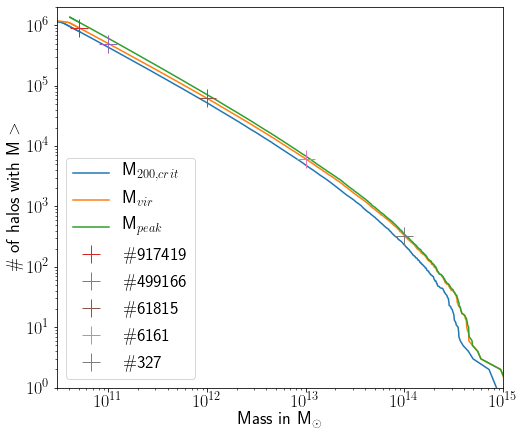

In [5]:
xMh = Nhalosin - np.arange(Nhalosin)
plt.loglog(np.sort(halos["halo_m200c"]), xMh, label=r"M$_{200,crit}$")
plt.semilogy(np.sort(halos["halo_mvir"]), xMh, label=r"M$_{vir}$")
plt.semilogy(np.sort(halos["halo_mpeak"]), xMh, label=r"M$_{peak}$")
for c, i in enumerate(ithresh):
    plt.plot(
        halos["halo_mvir"][i],
        xMh[i],
        "+",
        markersize=18,
        label=r"\#" + str(Nhthresh[c]),
    )
plt.xlabel("Mass in M$_\odot$")
plt.ylabel("$\#$ of halos with M $>$ ")
plt.xlim((3e10, 1e15))
plt.ylim((1, 2e6))

plt.legend()

Text(0.5, 1.0, 'halos $10^{12}<M<10^{13}$')

<Figure size 1440x1440 with 0 Axes>

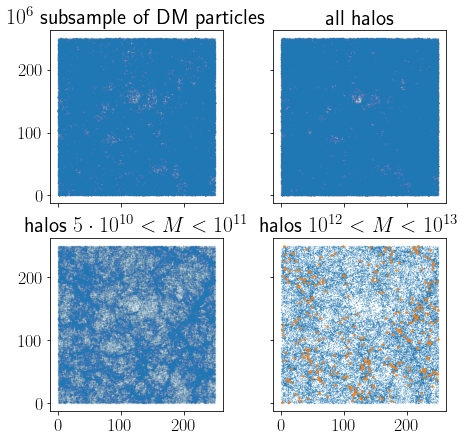

In [6]:
ff = plt.figure(figsize=(20, 20))
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex="col", sharey="row")

ax1.plot(particles["x"], particles["y"], ".", alpha=0.2, markersize=0.2)
ax2.plot(
    halos["halo_x"], halos["halo_y"], ".", alpha=(0.2 * 1.0 / 1.4), markersize=0.2
)  # adjust alpha according to halo/particle ratio

ax3.plot(
    halos["halo_x"][ithresh[0] : ithresh[1]],
    halos["halo_y"][ithresh[0] : ithresh[1]],
    ".",
    alpha=(0.2),
    markersize=0.2,
)  # adjust alpha accordin to halo/particle ratio
ax4.plot(
    halos["halo_x"][ithresh[2] : ithresh[3]],
    halos["halo_y"][ithresh[2] : ithresh[3]],
    ".",
    alpha=(0.2 * 5.0 / 0.6 / 4),
    markersize=0.4,
)  # adjust alpha accordin to halo/particle ratio
ax4.plot(
    halos["halo_x"][ithresh[4] :],
    halos["halo_y"][ithresh[4] :],
    ".",
    alpha=1,
    markersize=2.8,
)  # adjust alpha accordin to halo/particle ratio

ax1.set_aspect("equal")
ax2.set_aspect("equal")
ax3.set_aspect("equal")
ax4.set_aspect("equal")

f.subplots_adjust(wspace=0)
# f.subplots_adjust(hspace=0)

ax1.set_title("$10^6$ subsample of DM particles")
ax2.set_title("all halos")
ax3.set_title("halos $5\cdot 10^{10}<M< 10^{11}$")
ax4.set_title("halos $10^{12}<M<10^{13}$")

## Two point correlation function $\xi$

In [7]:
nbins = 30
bins = np.logspace(
    -1, 1.5, nbins + 1
)  # Note the + 1 to nbins, If you reduce the max to 1.3 (smaller max radius the calculation is much faster)

### A Poisson process has $\xi = 0$

In [8]:
seed = 42
np.random.seed(seed)
N = 1000000
X = np.random.uniform(0, boxsize, N)
Y = np.random.uniform(0, boxsize, N)
Z = np.random.uniform(0, boxsize, N)
weights = np.ones_like(X)
results = xi(boxsize, nthreads, bins[3::4], X, Y, Z, output_ravg=True)
print("                         ravg                              xi")
for r in results:
    print(
        "{0:10.6f} {1:10.6f} {2:10.6f} {3:10d} {4:10.6f} {5:10.4f}".format(
            r["rmin"], r["rmax"], r["ravg"], r["npairs"], r["weightavg"], r["xi"]
        )
    )

                         ravg                              xi
  0.177828   0.383119   0.304165      13704   0.000000     0.0100
  0.383119   0.825404   0.656305     134954   0.000000    -0.0053
  0.825404   1.778279   1.413740    1355710   0.000000    -0.0008
  1.778279   3.831187   3.044638   13573900   0.000000     0.0004
  3.831187   8.254042   6.559038  135669484   0.000000    -0.0001
  8.254042  17.782794  14.131043 1356761178   0.000000    -0.0000


In [9]:
dm_xi = xi(
    boxsize,
    nthreads,
    bins,
    particles["x"],
    particles["y"],
    particles["z"],
    output_ravg=True,
    verbose=True,
)

In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.115 sec
countpairs_xi_double> gridlink seems inefficient. nmesh = (15, 15, 7); avg_np = 635. Boosting bin refine factor - should lead to better performance
xmin = 0.000000 xmax=250.000000 rmax = 31.622777
In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,23,7.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 26.206 secs


Let's also check whether if we downsample the particles further we still get the same two point function:

In [10]:
sel = np.random.randint(0, len(particles), 100000)
dm_xi_ds5 = xi(
    boxsize,
    nthreads,
    bins,
    particles["x"][sel],
    particles["y"][sel],
    particles["z"][sel],
    output_ravg=True,
    verbose=True,
)
sel = np.random.randint(0, len(particles), 10000)
dm_xi_ds4 = xi(
    boxsize,
    nthreads,
    bins[::2],
    particles["x"][sel],
    particles["y"][sel],
    particles["z"][sel],
    output_ravg=True,
    verbose=False,
)
sel = np.random.randint(0, len(particles), 1000)
dm_xi_ds3 = xi(
    boxsize,
    nthreads,
    bins[5::3],
    particles["x"][sel],
    particles["y"][sel],
    particles["z"][sel],
    output_ravg=True,
    verbose=False,
)

In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 15,15,7.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.524 secs


Text(0, 0.5, '$\\xi(R)$')

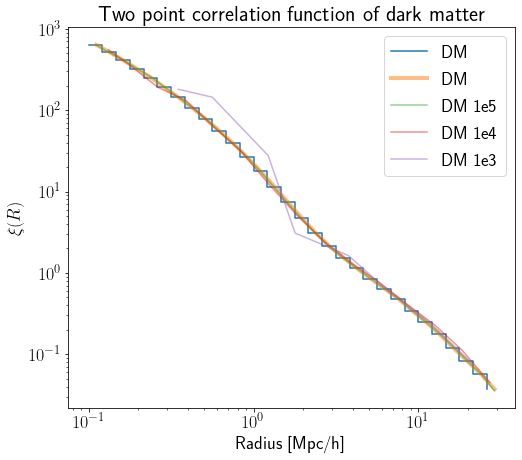

In [11]:
ax = plt.step(dm_xi["rmin"], dm_xi["xi"], where="post", label="DM")
ax = plt.plot(dm_xi["ravg"], dm_xi["xi"], label="DM", linewidth=4, alpha=0.5)
ax = plt.plot(dm_xi_ds5["ravg"], dm_xi_ds5["xi"], label="DM 1e5", alpha=0.5)
ax = plt.plot(dm_xi_ds4["ravg"], dm_xi_ds4["xi"], label="DM 1e4", alpha=0.5)
ax = plt.plot(dm_xi_ds3["ravg"], dm_xi_ds3["xi"], label="DM 1e3", alpha=0.5)

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.title("Two point correlation function of dark matter")
plt.xlabel("Radius [Mpc/h]")
plt.ylabel(r"$\xi(R)$")

Even with only 10,000 randomly downsampled points of the 1 million particles do we still arrive a quite accurate determination of the two point function.

Now we compare the underlying DM distribution two point correlation function to the one measured from our different halo samples. This will illustrate how halos of different mass are distributed distinctly different than the underlying DM density field.

In [12]:
h1_xi = xi(
    boxsize,
    nthreads,
    bins,
    halos["halo_x"][ithresh[0] : ithresh[1]],
    halos["halo_y"][ithresh[0] : ithresh[1]],
    halos["halo_z"][ithresh[0] : ithresh[1]],
    output_ravg=True,
    verbose=False,
)
h1b_xi = xi(
    boxsize,
    nthreads,
    bins,
    halos["halo_x"][ithresh[0] :],
    halos["halo_y"][ithresh[0] :],
    halos["halo_z"][ithresh[0] :],
    output_ravg=True,
    verbose=False,
)
h2_xi = xi(
    boxsize,
    nthreads,
    bins,
    halos["halo_x"][ithresh[1] : ithresh[2]],
    halos["halo_y"][ithresh[1] : ithresh[2]],
    halos["halo_z"][ithresh[1] : ithresh[2]],
    output_ravg=True,
    verbose=False,
)

In [13]:
h3_xi = xi(
    boxsize,
    nthreads,
    bins,
    halos["halo_x"][ithresh[2] : ithresh[3]],
    halos["halo_y"][ithresh[2] : ithresh[3]],
    halos["halo_z"][ithresh[2] : ithresh[3]],
    output_ravg=True,
    verbose=False,
)
h4_xi = xi(
    boxsize,
    nthreads,
    bins[4::1],
    halos["halo_x"][ithresh[3] : ithresh[4]],
    halos["halo_y"][ithresh[3] : ithresh[4]],
    halos["halo_z"][ithresh[3] : ithresh[4]],
    output_ravg=True,
    verbose=False,
)
h5_xi = xi(
    boxsize,
    nthreads,
    bins[14::2],
    halos["halo_x"][ithresh[4] :],
    halos["halo_y"][ithresh[4] :],
    halos["halo_z"][ithresh[4] :],
    output_ravg=True,
    verbose=False,
)

### Theory prediction

The collosus package (see reference at the very top of the document) provides many helpful routines relevant for cosmology and large scale structure.

In [16]:
cosmology.setCosmology("bolshoi")
cosmo = cosmology.getCurrent()

Nk = 1000  # number of wavenumber bins
z = 0.0
kw = np.logspace(-1.5, 3, Nk)
R = 2 * np.pi / kw
Pk = cosmo.matterPowerSpectrum(kw, z, model="eisenstein98_zb")
xik = cosmo.correlationFunction(R)
M = peaks.lagrangianM(R)
nu = peaks.peakHeight(M, z)
Mstar = peaks.nonLinearMass(z)
Rstar = peaks.lagrangianR(Mstar)
kstar = 2 * np.pi / Rstar
print("Mstar/1e12, kstar, Rstar:", Mstar / 1e12, kstar, Rstar)
b = bias.haloBiasFromNu(nu, model="sheth01")

Mstar/1e12, kstar, Rstar: 3.1854190982728796 2.9021191240755013 2.1650335629076416


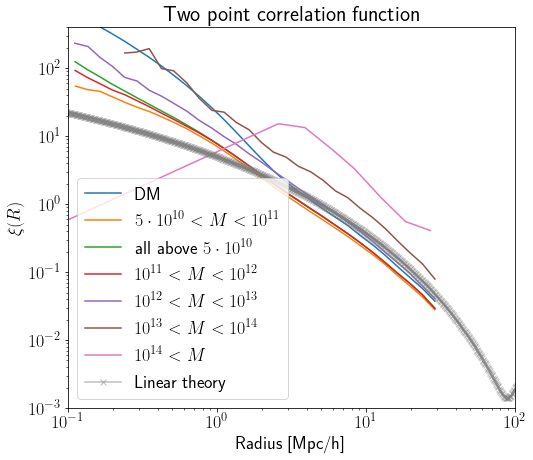

In [17]:
f = plt.loglog(dm_xi["ravg"], dm_xi["xi"], label="DM")
plt.loglog(h1_xi["ravg"], h1_xi["xi"], label="$5\cdot 10^{10} < M < 10^{11}$")
plt.loglog(h1b_xi["ravg"], h1b_xi["xi"], label="all above $5\cdot 10^{10}$")
plt.loglog(h2_xi["ravg"], h2_xi["xi"], label="$ 10^{11} < M < 10^{12}$")
plt.loglog(h3_xi["ravg"], (h3_xi["xi"]), label="$10^{12} < M < 10^{13}$")
plt.loglog(h4_xi["ravg"], (h4_xi["xi"]), label="$10^{13} < M < 10^{14}$")
plt.loglog(h5_xi["ravg"], h5_xi["xi"], label="$ 10^{14} < M $")
plt.loglog(R, xik, "x-", label="Linear theory", alpha=0.5)
plt.xlim((1e-1, 1e2))
plt.ylim((1e-3, 4e2))


plt.title("Two point correlation function")
plt.xlabel("Radius [Mpc/h]")
plt.ylabel(r"$\xi(R)$")
plt.legend()

$10^{12}$ solar mass halos are clusters on large scales ($>2$ Mpc/h) similar to the underlying dark matter distribution. Lower masses are less clustered and higher masses show much larger correlation strength at large radii.

To highlight how similar the two point functions behave at large scales one often plots $R^\gamma \xi(R)$ where $\gamma$

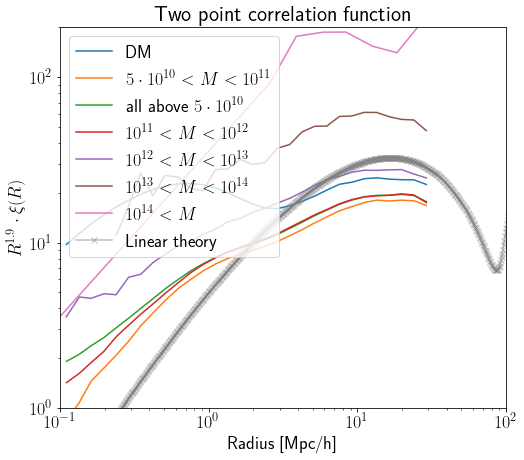

In [18]:
cpowlaw = 1.9
f = plt.loglog(dm_xi["ravg"], dm_xi["ravg"] ** cpowlaw * dm_xi["xi"], label="DM")
plt.plot(
    h1_xi["ravg"],
    h1_xi["ravg"] ** cpowlaw * h1_xi["xi"],
    label="$5\cdot 10^{10} < M < 10^{11}$",
)
plt.plot(
    h1b_xi["ravg"],
    h1b_xi["ravg"] ** cpowlaw * h1b_xi["xi"],
    label="all above $5\cdot 10^{10}$",
)
plt.plot(
    h2_xi["ravg"],
    h2_xi["ravg"] ** cpowlaw * h2_xi["xi"],
    label="$ 10^{11} < M < 10^{12}$",
)
plt.plot(
    h3_xi["ravg"],
    h3_xi["ravg"] ** cpowlaw * (h3_xi["xi"]),
    label="$10^{12} < M < 10^{13}$",
)
plt.plot(
    h4_xi["ravg"],
    h4_xi["ravg"] ** cpowlaw * (h4_xi["xi"]),
    label="$10^{13} < M < 10^{14}$",
)
plt.plot(h5_xi["ravg"], h5_xi["ravg"] ** cpowlaw * h5_xi["xi"], label="$ 10^{14} < M $")
plt.plot(R, R ** cpowlaw * xik, "x-", label="Linear theory", alpha=0.5)
plt.title("Two point correlation function")
plt.xlabel("Radius [Mpc/h]")
plt.ylabel(str(r"$R^{" + str(cpowlaw) + r"} \cdot \xi(R)$"))
plt.xlim((1e-1, 1e2))
plt.ylim((1e0, 2e2))

plt.legend()

The linear prediction here is larger by about 20%. This is larger than we would expect. Need to track down the discrepancy ... It may be a $h^{-1}$ somewhere?

In [19]:
print(cosmo)  # compared this to the simulation paper and this seems correct.

Cosmology "bolshoi" 
    flat = True, Om0 = 0.2700, Ode0 = 0.7300, Ob0 = 0.0469, H0 = 70.00, sigma8 = 0.8200, ns = 0.9500
    de_model = lambda, relspecies = False, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


## Powerspectra

In [20]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

plt.style.use(style.notebook)
setup_logging()

In [21]:
pcat = ArrayCatalog(
    {"Position": np.stack([particles["x"], particles["y"], particles["z"]], axis=1)}
)
Pkp = FFTPower(pcat, mode="1d", Nmesh=256, BoxSize=250).power

[ 000001.30 ]   0: 11-08 09:46  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 1000000 
[ 000001.91 ]   0: 11-08 09:46  CatalogMesh     INFO     painted 1000000 out of 1000000 objects to mesh
[ 000001.93 ]   0: 11-08 09:46  CatalogMesh     INFO     painted 1000000 out of 1000000 objects to mesh
[ 000001.93 ]   0: 11-08 09:46  CatalogMesh     INFO     mean particles per cell is 0.0596046
[ 000001.93 ]   0: 11-08 09:46  CatalogMesh     INFO     sum is 1e+06 
[ 000001.98 ]   0: 11-08 09:46  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000002.42 ]   0: 11-08 09:46  CatalogMesh     INFO     field: (ArrayCatalog(size=1000000) as CatalogMesh) painting done


In [22]:
pcat = ArrayCatalog(
    {
        "Position": np.stack(
            [halos["halo_x"], halos["halo_y"], halos["halo_z"]], axis=1
        )[ithresh[0] : ithresh[1], :]
    }
)
Pkh1 = FFTPower(pcat, mode="1d", Nmesh=256, BoxSize=250).power
pcat = ArrayCatalog(
    {
        "Position": np.stack(
            [halos["halo_x"], halos["halo_y"], halos["halo_z"]], axis=1
        )[ithresh[0] :, :]
    }
)
Pkh1b = FFTPower(pcat, mode="1d", Nmesh=256, BoxSize=250).power
pcat = ArrayCatalog(
    {
        "Position": np.stack(
            [halos["halo_x"], halos["halo_y"], halos["halo_z"]], axis=1
        )[ithresh[1] : ithresh[2], :]
    }
)
Pkh2 = FFTPower(pcat, mode="1d", Nmesh=256, BoxSize=250).power
pcat = ArrayCatalog(
    {
        "Position": np.stack(
            [halos["halo_x"], halos["halo_y"], halos["halo_z"]], axis=1
        )[ithresh[2] : ithresh[3], :]
    }
)
Pkh3 = FFTPower(pcat, mode="1d", Nmesh=256, BoxSize=250).power
pcat = ArrayCatalog(
    {
        "Position": np.stack(
            [halos["halo_x"], halos["halo_y"], halos["halo_z"]], axis=1
        )[ithresh[3] : ithresh[4], :]
    }
)
Pkh4 = FFTPower(pcat, mode="1d", Nmesh=256, BoxSize=250).power
pcat = ArrayCatalog(
    {
        "Position": np.stack(
            [halos["halo_x"], halos["halo_y"], halos["halo_z"]], axis=1
        )[ithresh[4] :, :]
    }
)
Pkh5 = FFTPower(pcat, mode="1d", Nmesh=256, BoxSize=250).power

[ 000004.67 ]   0: 11-08 09:46  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 418253 
[ 000004.97 ]   0: 11-08 09:46  CatalogMesh     INFO     painted 418253 out of 418253 objects to mesh
[ 000004.98 ]   0: 11-08 09:46  CatalogMesh     INFO     painted 418253 out of 418253 objects to mesh
[ 000004.98 ]   0: 11-08 09:46  CatalogMesh     INFO     mean particles per cell is 0.0249298
[ 000004.98 ]   0: 11-08 09:46  CatalogMesh     INFO     sum is 418253 
[ 000005.02 ]   0: 11-08 09:46  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000005.45 ]   0: 11-08 09:46  CatalogMesh     INFO     field: (ArrayCatalog(size=418253) as CatalogMesh) painting done
[ 000006.34 ]   0: 11-08 09:46  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 917418 
[ 000006.87 ]   0: 11-08 09:46  CatalogMesh     INFO     painted 917418 out of 917418 objects to mesh
[ 000006.88 ]   0: 11-08 09:46  CatalogMesh     INFO     painted 917418 out of 917418 objects to mesh
[ 000006.88 ]   0: 11-08 09:46  Catalog

(10, 50000.0)

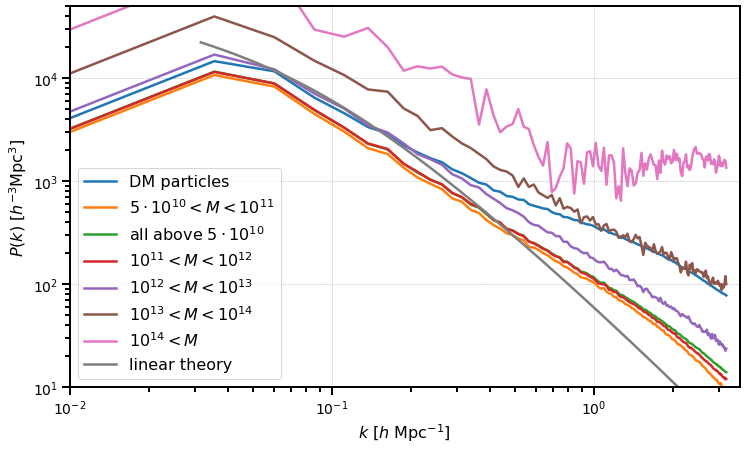

In [23]:
# print the shot noise subtracted P(k)
plt.loglog(Pkp["k"], Pkp["power"].real - Pkp.attrs["shotnoise"], label="DM particles")
plt.loglog(
    Pkh1["k"],
    Pkh1["power"].real - Pkh1.attrs["shotnoise"],
    label="$5\cdot 10^{10} < M < 10^{11}$",
)
plt.loglog(
    Pkh1b["k"],
    Pkh1b["power"].real - Pkh1b.attrs["shotnoise"],
    label="all above $5\cdot 10^{10}$",
)
plt.loglog(
    Pkh2["k"],
    Pkh2["power"].real - Pkh2.attrs["shotnoise"],
    label="$ 10^{11} < M < 10^{12}$",
)
plt.loglog(
    Pkh3["k"],
    Pkh3["power"].real - Pkh3.attrs["shotnoise"],
    label="$10^{12} < M < 10^{13}$",
)
plt.loglog(
    Pkh4["k"],
    Pkh4["power"].real - Pkh4.attrs["shotnoise"],
    label="$10^{13} < M < 10^{14}$",
)
plt.loglog(
    Pkh5["k"], Pkh5["power"].real - Pkh5.attrs["shotnoise"], label="$ 10^{14} < M $"
)

plt.plot(kw, Pk, label="linear theory")
# format the axes
plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 3.6)
plt.ylim(10, 5e4)

Very clearly the Powespectrum carries the same information as the two point correlation function. At low k the ratio of the power spectra are identical as what we found for $\xi(R)$ at large radii.
They are a Fourier transform pair:
$\xi(R) = \frac{1}{(2\pi)^d} \int_{-\infty}^\infty \,e^{-i\bf{k}\cdot\bf{R}}\, P({\bf k})\,d^d k$.

The transform from our 3D power spectra is that we can can infer the Powerspectrum from the two point function using
$$ P(k) = \int_0^\infty \xi(r) \frac{\sin(kr)}{kr} 4\pi r^2 dr $$

Similarly we can obtain $\xi(R)$ from $P(k)$ via:
$$ \xi(R) = \frac{1}{(2\pi)^3} \int_0^\infty P(k) \frac{\sin(kr)}{kr} 4\pi k^2 dk = \frac{1}{(2\pi)^3} \int_0^\infty P(k) \frac{\sin(kr)}{r} 4\pi k dk $$



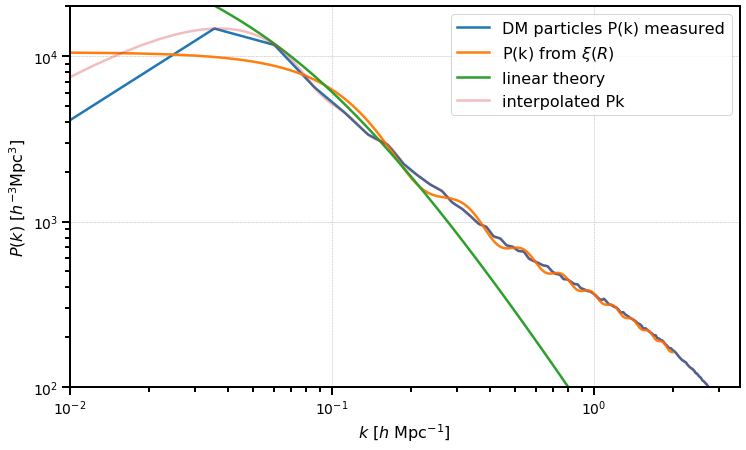

In [24]:
# First we interpolate the measured values using cubic splines
xi_dm_f = interpolate.interp1d(dm_xi["ravg"], dm_xi["xi"], kind=3)
xg = np.linspace(np.min(dm_xi["ravg"]), np.max(dm_xi["ravg"]), 1024)
xi_dm_g = xi_dm_f(xg)

Pk_dm_f = interpolate.interp1d(
    Pkp["k"], Pkp["power"].real - Pkp.attrs["shotnoise"], kind=3
)
kg = np.linspace(np.min(Pkp["k"]), np.max(Pkp["k"]), 1024)
Pk_dm_g = Pk_dm_f(kg)
# Now we can integrate
Nint = 800
kint = np.logspace(-2, 0.3, Nint)
Rint = np.logspace(-2, 2, Nint)
Pint = np.zeros(Nint)
xiint = np.zeros(Nint)
for i in range(Nint):
    Pint[i] = integrate.simps(
        xi_dm_g * np.sin(xg * kint[i]) / (xg * kint[i]) * 4 * np.pi * xg ** 2, xg
    )
    xiint[i] = (
        1
        / (2 * np.pi) ** 3
        * integrate.simps(
            Pk_dm_g * np.sin(Rint[i] * kg) / (Rint[i]) * 4 * np.pi * kg, kg
        )
    )
# and plot results
plt.loglog(
    Pkp["k"],
    Pkp["power"].real - Pkp.attrs["shotnoise"],
    label="DM particles P(k) measured",
)
plt.loglog(kint, Pint, "-", label=r"P(k) from $\xi(R)$")
plt.plot(kw, Pk, label="linear theory")
plt.plot(kg, Pk_dm_g, alpha=0.3, label="interpolated Pk")

plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 3.6)
plt.ylim(100, 2e4)
plt.legend()

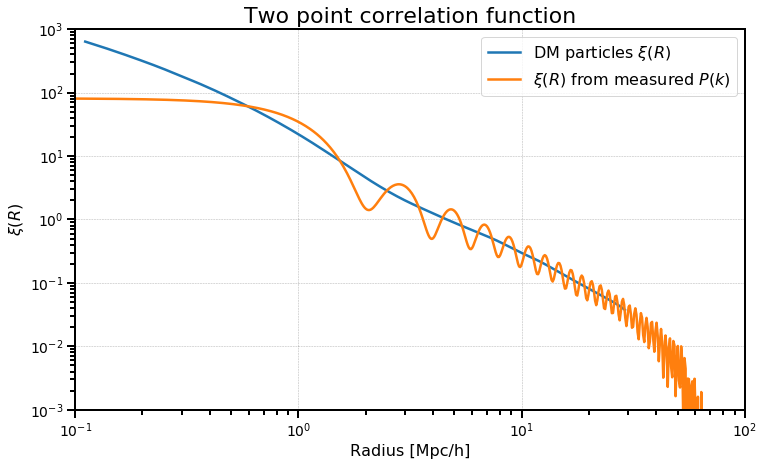

In [25]:
plt.loglog(xg, xi_dm_g, label=r"DM particles $\xi(R)$")
plt.plot(Rint, xiint, label=r"$\xi(R)$ from measured $P(k)$")
plt.title("Two point correlation function")
plt.xlabel("Radius [Mpc/h]")
plt.ylabel(r"$\xi(R)$")
plt.xlim(1e-1, 1e2)
plt.ylim(1e-3, 1e3)
plt.legend()

The reconstruction of the two point function from the measured power-spectrum is not as successful. Likely becaues of the sharp feature in the two point function it would require more modes to be reconstructed.

## Void Probability Function and Counts in Cell

In [51]:
from Corrfunc.theory.vpf import vpf

rmax = 10.0
#rmax = 5.0
nbins = 15
nspheres = 500000
#nspheres = 5000
numpN = 135
seed = 42
# FIRST THE POISSON DISTRIBUTION
vpfp = vpf(
    rmax,
    nbins,
    nspheres,
    numpN,
    seed,
    X,
    Y,
    Z,
    periodic=True,
    boxsize=250,
    verbose=True,
)

In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,25,25.  Time taken =   0.153 sec
Running with [xmin,xmax] = 0.000130,249.999579 with periodic wrapping = 250.000000
Running with [ymin,ymax] = 0.000094,249.999846 with periodic wrapping = 250.000000
Running with [zmin,zmax] = 0.000249,249.999472 with periodic wrapping = 250.000000
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  6.259 secs


In [52]:
print (vpfp["pN"])

[[9.23558e-01 7.34080e-02 2.96600e-03 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [5.28870e-01 3.37254e-01 1.06916e-01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.16772e-01 2.50446e-01 2.70082e-01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 ...
 [0.00000e+00 0.00000e+00 0.00000e+00 ... 1.32000e-04 1.60000e-04
  2.20000e-04]
 [0.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


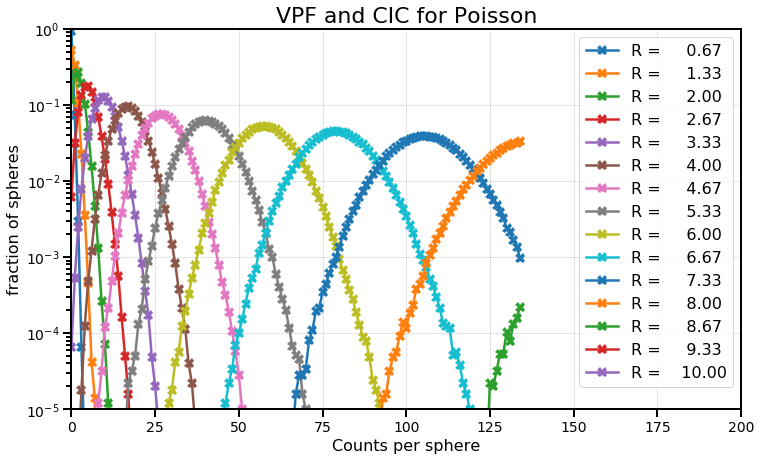

In [53]:
xNN = np.arange(len(vpfp["pN"][0]))
print (xNN)
for i, rad in enumerate(vpfp["rmax"]):
    print(i)
for i, rad in enumerate(vpfp["rmax"]):
    plt.plot(xNN, vpfp["pN"][i], "X-", label=r"R = {0:8.2f}".format(rad))

plt.xlabel("Counts per sphere")
plt.ylabel("fraction of spheres")
plt.yscale("log")
plt.title("VPF and CIC for Poisson")
plt.ylim(1e-5, 1)
plt.xlim(0, 200)

plt.legend()

<Figure size 1440x1440 with 0 Axes>

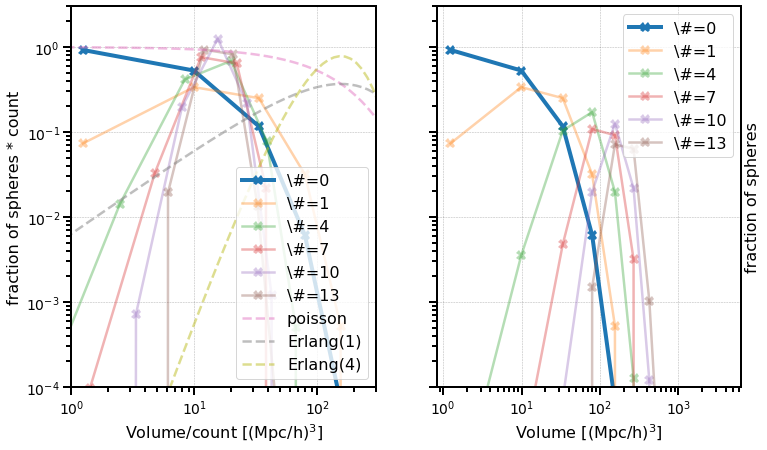

In [54]:
VNN = vpfp["rmax"] ** 3 * 4 * np.pi / 3

ff = plt.figure(figsize=(20, 20))
f, ((ax1, ax2)) = plt.subplots(1, 2, sharey="row")

sskip = 3
ax2.loglog(VNN, vpfp["pN"][:, 0], "X-", label=r"\#=0", linewidth=4)
for i, rad in enumerate(vpfp["rmax"][1::sskip]):
    ax2.plot(
        VNN,
        vpfp["pN"][:, i * sskip + 1],
        "X-",
        label=r"\#=" + str(i * sskip + 1),
        alpha=0.35,
    )

ax1.loglog(VNN, vpfp["pN"][:, 0], "X-", label=r"\#=0", linewidth=4)
for i, rad in enumerate(vpfp["rmax"][1::sskip]):
    ax1.plot(
        VNN / (i * sskip + 1),
        vpfp["pN"][:, i * sskip + 1] * (i * sskip + 1),
        "X-",
        label=r"\#=" + str(i * sskip + 1),
        alpha=0.35,
    )

xV = np.logspace(-1, 3.5, 100)
lamP = 1e5 / 250 ** 3
ax1.plot(xV, np.exp(-xV * lamP), "--", label="poisson", alpha=0.5)
ax1.plot(xV, lamP * xV * np.exp(-xV * lamP), "--", label="Erlang(1)", alpha=0.5)
ax1.plot(
    xV,
    (4 * lamP * xV) ** 4 / (2 * 3) * np.exp(-xV * lamP * 4),
    "--",
    label="Erlang(4)",
    alpha=0.5,
)

ax1.set_xlim(1,300)
ax2.set_xlabel(r"Volume [(Mpc/h)$^3$]")
ax2.set_ylabel("fraction of spheres")
ax2.yaxis.set_label_position("right")

plt.yscale("log")
plt.xscale("log")
ax1.set_xlabel(r"Volume/count [(Mpc/h)$^3$]")
ax1.set_ylabel("fraction of spheres * count")

ax1.legend()
plt.ylim(1e-4, 3e0)
plt.legend()

Clearly the Erlang distribution exactly fits the count in cells for the random uniform distribution.

### Now for the DM particles

In [30]:
numpN = 1250
vpfr = vpf(
    rmax,
    nbins,
    nspheres,
    numpN,
    seed,
    particles["x"],
    particles["y"],
    particles["z"],
    periodic=True,
    boxsize=250,
    verbose=True,
)

In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 16,16,16.  Time taken =   0.056 sec
Running with [xmin,xmax] = 0.000097,249.999847 with periodic wrapping = 250.000000
Running with [ymin,ymax] = 0.000127,249.999817 with periodic wrapping = 250.000000
Running with [zmin,zmax] = 0.000037,249.999847 with periodic wrapping = 250.000000
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 16.823 secs


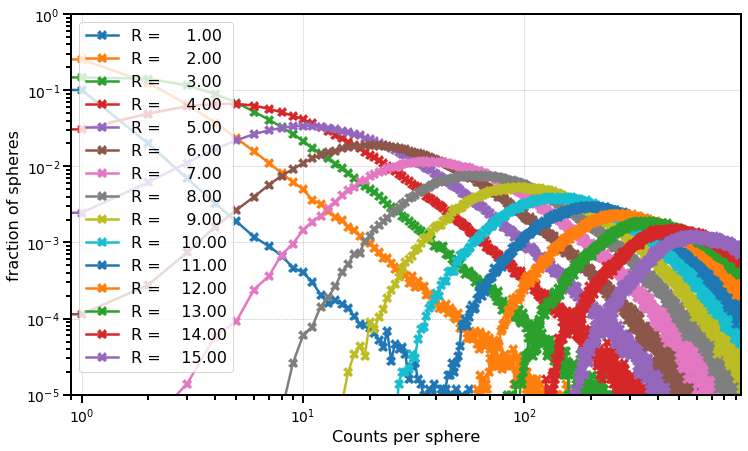

In [31]:
xNN = np.arange(len(vpfr["pN"][0]))
for i, rad in enumerate(vpfr["rmax"]):
    plt.plot(xNN, vpfr["pN"][i], "X-", label=r"R = {0:8.2f}".format(rad))

plt.xlabel("Counts per sphere")
plt.ylabel("fraction of spheres")
plt.yscale("log")
plt.xscale("log")

plt.ylim(1e-5, 1)
plt.xlim(0.9, 950)
plt.legend()

<Figure size 1440x1440 with 0 Axes>

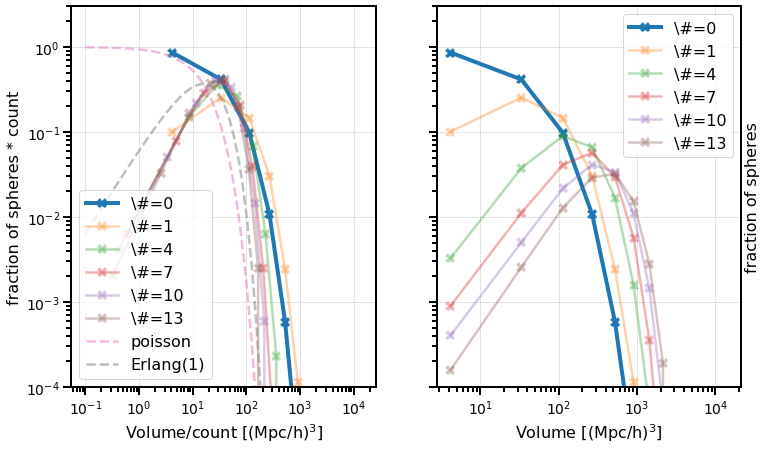

In [32]:
VNN = vpfr["rmax"] ** 3 * 4 * np.pi / 3

ff = plt.figure(figsize=(20, 20))
f, (ax1, ax2) = plt.subplots(1, 2, sharey="row")

sskip = 3
ax2.loglog(VNN, vpfr["pN"][:, 0], "X-", label=r"\#=0", linewidth=4)
for i, rad in enumerate(vpfr["rmax"][1::sskip]):
    ax2.plot(
        VNN,
        vpfr["pN"][:, i * sskip + 1],
        "X-",
        label=r"\#=" + str(i * sskip + 1),
        alpha=0.35,
    )

ax1.loglog(VNN, vpfr["pN"][:, 0], "X-", label=r"\#=0", linewidth=4)
for i, rad in enumerate(vpfr["rmax"][1::sskip]):
    ax1.plot(
        VNN / (i * sskip + 1),
        vpfr["pN"][:, i * sskip + 1] * (i * sskip + 1),
        "X-",
        label=r"\#=" + str(i * sskip + 1),
        alpha=0.35,
    )

xV = np.logspace(-1, 3.5, 100)
lamP = 1e6 / 250 ** 3
ax1.plot(xV, np.exp(-xV * lamP), "--", label="poisson", alpha=0.5)
ax1.plot(xV, lamP * xV * np.exp(-xV * lamP), "--", label="Erlang(1)", alpha=0.5)


ax2.set_xlabel(r"Volume [(Mpc/h)$^3$]")
ax2.set_ylabel("fraction of spheres")
ax2.yaxis.set_label_position("right")

plt.yscale("log")
plt.xscale("log")
ax1.set_xlabel(r"Volume/count [(Mpc/h)$^3$]")
ax1.set_ylabel("fraction of spheres * count")

ax1.legend()
plt.ylim(1e-4, 3e0)
plt.legend()

### VPFs of halos

In [33]:
numpN = 1250
vpfh1 = vpf(
    rmax,
    nbins,
    nspheres,
    numpN,
    seed,
    halos["halo_x"][ithresh[0] : ithresh[1]],
    halos["halo_y"][ithresh[0] : ithresh[1]],
    halos["halo_z"][ithresh[0] : ithresh[1]],
    periodic=True,
    boxsize=250,
    verbose=True,
)
vpfh2 = vpf(
    rmax,
    nbins,
    nspheres,
    numpN,
    seed,
    halos["halo_x"][ithresh[1] : ithresh[2]],
    halos["halo_y"][ithresh[1] : ithresh[2]],
    halos["halo_z"][ithresh[1] : ithresh[2]],
    periodic=True,
    boxsize=250,
    verbose=True,
)
vpfh3 = vpf(
    rmax,
    nbins,
    nspheres,
    numpN,
    seed,
    halos["halo_x"][ithresh[2] : ithresh[3]],
    halos["halo_y"][ithresh[2] : ithresh[3]],
    halos["halo_z"][ithresh[2] : ithresh[3]],
    periodic=True,
    boxsize=250,
    verbose=True,
)
vpfh4 = vpf(
    rmax,
    nbins,
    nspheres,
    numpN,
    seed,
    halos["halo_x"][ithresh[3] : ithresh[4]],
    halos["halo_y"][ithresh[3] : ithresh[4]],
    halos["halo_z"][ithresh[3] : ithresh[4]],
    periodic=True,
    boxsize=250,
    verbose=True,
)
vpfh5 = vpf(
    rmax,
    nbins,
    nspheres,
    numpN,
    seed,
    halos["halo_x"][ithresh[4] :],
    halos["halo_y"][ithresh[4] :],
    halos["halo_z"][ithresh[4] :],
    periodic=True,
    boxsize=250,
    verbose=True,
)

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 16,16,16.  Time taken =   0.024 sec
Running with [xmin,xmax] = 0.000390,249.999115 with periodic wrapping = 250.000000
Running with [ymin,ymax] = 0.000400,249.999725 with periodic wrapping = 250.000000
Running with [zmin,zmax] = 0.000010,249.998810 with periodic wrapping = 250.000000
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  8.534 secs
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 16,16,16.  Time taken =   0.025 sec
Running with [xmin,xmax] = 0.001390,249.999023 with periodic wrapping = 250.000000
Running with [ymin,ymax] = 0.000810,249.998184 with periodic wrapping = 250.000000
Running with [zmin,zmax] = 0.000270,249.999542 with periodic wrapping = 250.000000
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  7.834

Text(0, 0.5, 'fraction of empty spheres')

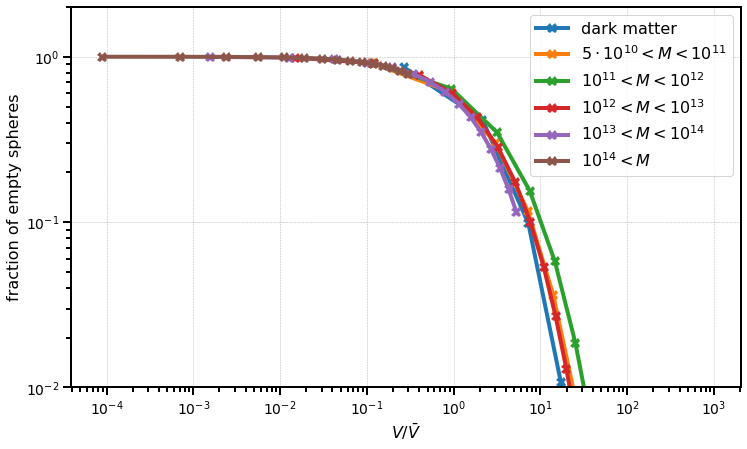

In [34]:
lw = 4
plt.loglog(
    VNN / (250 ** 3 / 1e6), vpfr["pN"][:, 0], "X-", linewidth=lw, label="dark matter"
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[0] - Nhthresh[1])),
    vpfh1["pN"][:, 0],
    "X-",
    linewidth=lw,
    label="$5\cdot 10^{10} < M < 10^{11}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[1] - Nhthresh[2])),
    vpfh2["pN"][:, 0],
    "X-",
    linewidth=lw,
    label="$ 10^{11} < M < 10^{12}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[2] - Nhthresh[3])),
    vpfh3["pN"][:, 0],
    "X-",
    linewidth=lw,
    label="$10^{12} < M < 10^{13}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[3] - Nhthresh[4])),
    vpfh4["pN"][:, 0],
    "X-",
    linewidth=lw,
    label="$10^{13} < M < 10^{14}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[4])),
    vpfh5["pN"][:, 0],
    "X-",
    linewidth=lw,
    label="$ 10^{14} < M $",
)

plt.ylim(1e-2, 2)
plt.legend()
plt.xlabel(r"$V/\bar{V}$")
plt.ylabel("fraction of empty spheres")

In [35]:
from scipy.special import gamma

gamma(4)

6.0

In [36]:
def Erlang(k, lam, x):
    if k == 0:
        klamx = lam * x
        gammak = 1
    else:
        klamx = k * lam * x
        gammak = gamma(k)
    return (klamx) ** k / gammak * np.exp(-klamx)

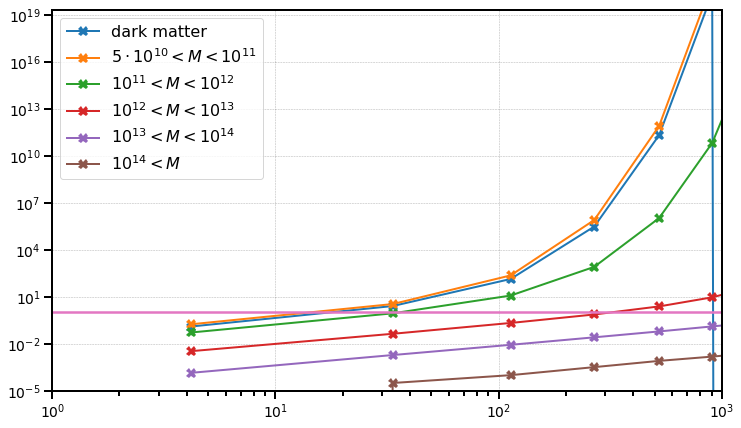

In [37]:
lw = 2
plt.loglog(
    VNN,
    vpfr["pN"][:, 0] / Erlang(0, (1e6 / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="dark matter",
)
plt.loglog(
    VNN,
    np.abs(vpfh1["pN"][:, 0] / Erlang(0, (Nhthresh[0] / 250 ** 3), VNN) - 1),
    "X-",
    linewidth=lw,
    label="$5\cdot 10^{10} < M < 10^{11}$",
)
plt.loglog(
    VNN,
    vpfh2["pN"][:, 0] / Erlang(0, (Nhthresh[1] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$ 10^{11} < M < 10^{12}$",
)
plt.loglog(
    VNN,
    vpfh3["pN"][:, 0] / Erlang(0, (Nhthresh[2] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$10^{12} < M < 10^{13}$",
)
plt.loglog(
    VNN,
    vpfh4["pN"][:, 0] / Erlang(0, (Nhthresh[3] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$10^{13} < M < 10^{14}$",
)
plt.loglog(
    VNN,
    vpfh5["pN"][:, 0] / Erlang(0, (Nhthresh[4] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$ 10^{14} < M $",
)
plt.plot([1e-3, 1e6], [1, 1])

plt.xlim(1, 1e3)
plt.ylim(1e-5, 2e19)
plt.legend()

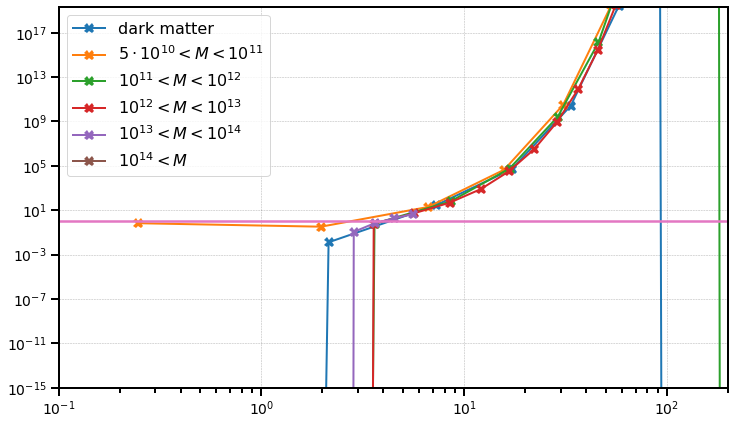

In [38]:
lw = 2
plt.loglog(
    VNN / (250 ** 3 / 1e6),
    vpfr["pN"][:, 1] / Erlang(1, (1e6 / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="dark matter",
)
plt.loglog(
    VNN / (250 ** 3 / Nhthresh[0]),
    np.abs(vpfh1["pN"][:, 1] / Erlang(1, (Nhthresh[0] / 250 ** 3), VNN) - 1),
    "X-",
    linewidth=lw,
    label="$5\cdot 10^{10} < M < 10^{11}$",
)
plt.loglog(
    VNN / (250 ** 3 / Nhthresh[1]),
    vpfh2["pN"][:, 1] / Erlang(1, (Nhthresh[1] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$ 10^{11} < M < 10^{12}$",
)
plt.loglog(
    VNN / (250 ** 3 / Nhthresh[2]),
    vpfh3["pN"][:, 1] / Erlang(1, (Nhthresh[2] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$10^{12} < M < 10^{13}$",
)
plt.loglog(
    VNN / (250 ** 3 / Nhthresh[3]),
    vpfh4["pN"][:, 1] / Erlang(1, (Nhthresh[3] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$10^{13} < M < 10^{14}$",
)
plt.loglog(
    VNN / (250 ** 3 / Nhthresh[4]),
    vpfh5["pN"][:, 1] / Erlang(1, (Nhthresh[4] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$ 10^{14} < M $",
)
plt.plot([1e-3, 1e6], [1, 1])
plt.ylim(1e-15, 2e19)
plt.xlim(1e-1, 2e2)
plt.legend()

In [39]:
import scipy.special as special

special.gammainc(0, 0.1)

nan

In [40]:
def rhokNN(xin, xout, kin, periodic=0):
    """ Calculate nearest neighbor density at the xout locations
    to points specificed by xin. 
    kin can be a """
    dim = xin.shape[1]
    Npoints = xin.shape[0]
    xtree = scipy.spatial.cKDTree(xin, boxsize=periodic)
    if periodic > 0:  # assumes rectangular volume
        totalVol = periodic ** dim
    else:
        totalVol = 1
        for i in range(dim):
            totalVol *= np.max(xin[:, i]) - np.min(xin[:, i])
    if isinstance(kin, int):
        kin = [kin]
    print(dim, Npoints, totalVol)
    dis, disi = xtree.query(xout, k=kin, n_jobs=-1)
    disi = 0  # discard indices
    rho = np.empty_like(dis)
    Cr = [2, np.pi, 4 * np.pi / 3][dim - 1]  # Volume prefactor for 1,2, 3D
    dm = totalVol / Npoints
    for c, k in enumerate(np.nditer(np.array(kin))):
        oovol = k / dis[:, c] ** dim
        rho[:, c] = dm * oovol / Cr
    return rho, dis


def VPFkNN(xin, xout, k=1, periodic=0):
    r, dis = rhokNN(xin, xout, k, periodic=periodic)
    V = 1.0 / r[:, 0]
    V = np.sort(V)
    N = len(V)
    CDF = (np.arange(0, N) + 1) / N
    return CDF, V

In [41]:
np.random.seed(42)
xoutt = np.random.rand(1000000, 3) * 250
xint = np.random.rand(1000000, 3) * 250
np.floor(len(xoutt) ** 0.3334)
Nplg = int(len(xoutt) ** 0.3334)
xpoi = boxsize * (np.arange(0, Nplg) + 0.5) / Nplg
xoutg = np.array(np.meshgrid(xpoi, xpoi, xpoi, indexing="xy"))
xoutg = xoutg.T.reshape(Nplg ** 3, 3)

ktest = [1, 2, 3, 5, 10, 30, 100]
xpd = np.vstack((particles["x"], particles["y"], particles["z"])).T.reshape(
    len(particles["x"]), 3
)
CDFdm, Vdm = VPFkNN(xpd, xoutt, periodic=250)
CDFdmg, Vdmg = VPFkNN(xpd, xoutg, periodic=250)
CDFs, Vs = VPFkNN(xint, xoutt, periodic=250)
skipi = 100
CDFdm = CDFdm[::skipi]
Vdm = Vdm[::skipi]
CDFdmg = CDFdmg[::skipi]
Vdmg = Vdmg[::skipi]
CDFs = CDFs[::skipi]
Vs = Vs[::skipi]

3 1000000 15625000
3 1000000 15625000
3 1000000 15625000


In [42]:
np.median(Vs)

0.6933370356573727

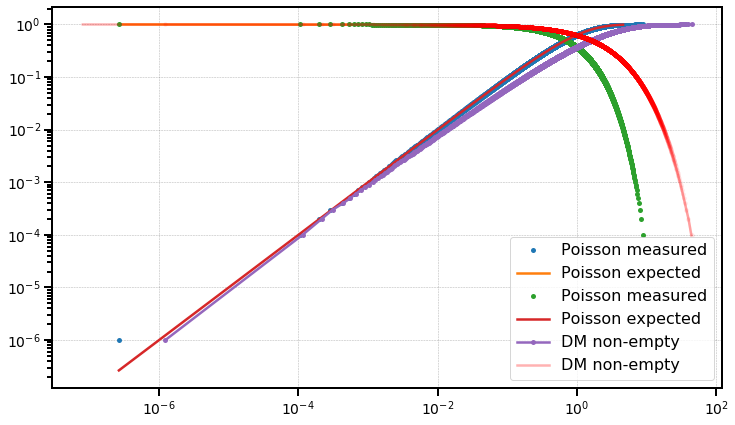

In [43]:
me = 1
plt.plot(Vs, CDFs, ".", markevery=me, label="Poisson measured")
plt.plot(Vs[::100], np.exp(-Vs)[::100], label="Poisson expected")
plt.plot(Vs, 1 - CDFs, ".", markevery=me, label="Poisson measured")
plt.plot(Vs[::100], 1 - np.exp(-Vs[::100]), markevery=me, label="Poisson expected")

plt.plot(Vdm, CDFdm, ".-", markevery=me, label="DM non-empty")
plt.plot(Vdm, 1 - CDFdm, "r.-", markevery=me, alpha=0.1, ms=8.9)
plt.plot(Vdmg, 1 - CDFdmg, "r.-", markevery=me, alpha=0.3, ms=0.2, label="DM non-empty")

plt.legend()
plt.yscale("log")
plt.xscale("log")

Now lets compare with the traditional VPF approach from earlier.

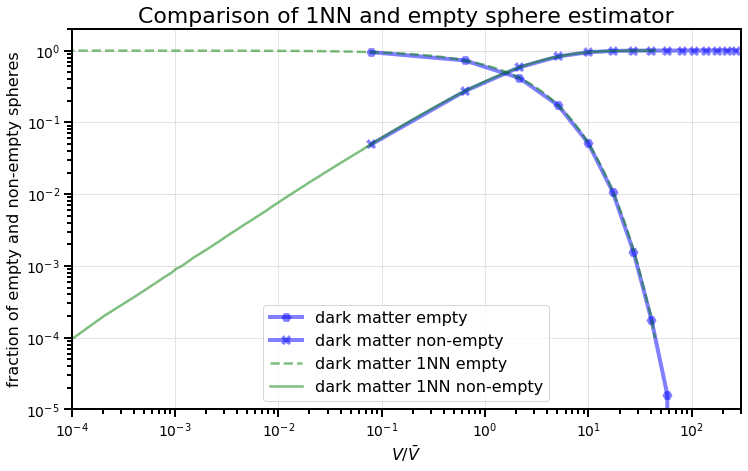

In [57]:
lw = 4
plt.loglog(
    VNN / (250 ** 3 / 1e6),
    vpfr["pN"][:, 0],
    "bH-",
    linewidth=lw,
    alpha=0.5,
    label="dark matter empty",
)
plt.loglog(
    VNN / (250 ** 3 / 1e6),
    1 - vpfr["pN"][:, 0],
    "bX-",
    linewidth=lw,
    alpha=0.5,
    label="dark matter non-empty",
)
# plt.loglog(VNN/(250**3/Nhthresh[0]), vpfh1["pN"][:,0], 'X-',linewidth=lw, label="$5\cdot 10^{10} < M < 10^{11}$")
# plt.loglog(VNN/(250**3/Nhthresh[1]), vpfh2["pN"][:,0], 'X-',linewidth=lw, label="$ 10^{11} < M < 10^{12}$")
# plt.loglog(VNN/(250**3/Nhthresh[2]), vpfh3["pN"][:,0], 'X-',linewidth=lw, label="$10^{12} < M < 10^{13}$")
# plt.loglog(VNN/(250**3/Nhthresh[3]), vpfh4["pN"][:,0], 'X-',linewidth=lw, label="$10^{13} < M < 10^{14}$")
# plt.loglog(VNN/(250**3/Nhthresh[4]), vpfh5["pN"][:,0], 'X-',linewidth=lw, label="$ 10^{14} < M $")

plt.plot(Vdmg, 1 - CDFdmg, "g--", ms=3, alpha=0.5, label="dark matter 1NN empty")
plt.plot(Vdmg, CDFdmg, "g-", ms=3, alpha=0.5, label="dark matter 1NN non-empty")

plt.xlabel(r"$V/\bar{V}$")
plt.ylabel("fraction of empty and non-empty spheres")
plt.title("Comparison of 1NN and empty sphere estimator")
plt.xlim(1e-4, 3e2)
plt.ylim(1e-5, 2)
plt.legend()

Indeed the nearest neighbor density estimator measures exactly the void probability function without requiring binning.

In [58]:

xpd = np.vstack((particles["x"], particles["y"], particles["z"])).T.reshape(
    len(particles["x"]), 3
)
xph1 = np.vstack(
    (
        halos["halo_x"][ithresh[0] : ithresh[1]],
        halos["halo_y"][ithresh[0] : ithresh[1]],
        halos["halo_z"][ithresh[0] : ithresh[1]],
    )
).T.reshape(len(halos["halo_x"][ithresh[0] : ithresh[1]]), 3)
xph2 = np.vstack(
    (
        halos["halo_x"][ithresh[1] : ithresh[2]],
        halos["halo_y"][ithresh[1] : ithresh[2]],
        halos["halo_z"][ithresh[1] : ithresh[2]],
    )
).T.reshape(len(halos["halo_x"][ithresh[1] : ithresh[2]]), 3)
xph3 = np.vstack(
    (
        halos["halo_x"][ithresh[2] : ithresh[3]],
        halos["halo_y"][ithresh[2] : ithresh[3]],
        halos["halo_z"][ithresh[2] : ithresh[3]],
    )
).T.reshape(len(halos["halo_x"][ithresh[2] : ithresh[3]]), 3)

CDFh1, Vsh1 = VPFkNN(xph1, xoutt, periodic=250)
CDFh2, Vsh2 = VPFkNN(xph2, xoutt, periodic=250)
CDFh3, Vsh3 = VPFkNN(xph3, xoutt, periodic=250)

3 418253 15625000
3 437351 15625000
3 55654 15625000


/Users/tabel/anaconda3/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/tabel/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


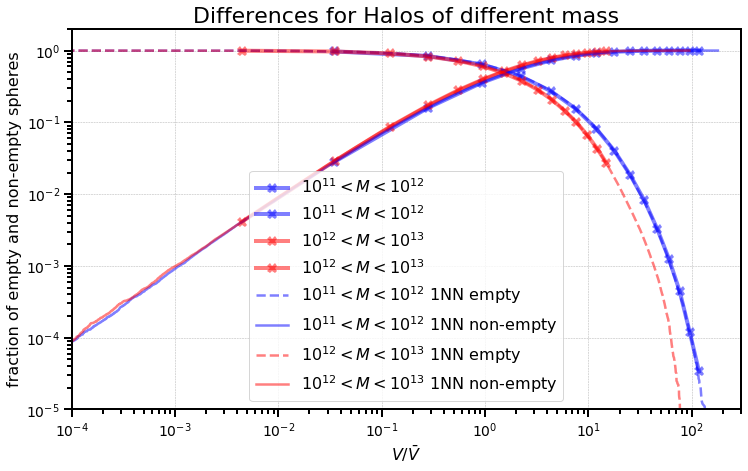

In [59]:
lw = 4
# plt.loglog(VNN/(250**3/1e6), vpfr["pN"][:,0], 'bH-',linewidth=lw, alpha=.5, label="dark matter empty")
# plt.loglog(VNN/(250**3/1e6), 1- vpfr["pN"][:,0], 'bX-',linewidth=lw, alpha=.5, label="dark matter non-empty")
# plt.loglog(VNN/(250**3/(Nhthresh[0]-Nhthresh[1])), vpfh1["pN"][:,0], 'bH-',linewidth=lw, alpha=.5, label="$5\cdot 10^{10} < M < 10^{11}$")
# plt.loglog(VNN/(250**3/(Nhthresh[0]-Nhthresh[1])), 1-vpfh1["pN"][:,0], 'bX-',linewidth=lw, alpha=.5, label="$5\cdot 10^{10} < M < 10^{11}$")
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[1] - Nhthresh[2])),
    vpfh2["pN"][:, 0],
    "bX-",
    linewidth=lw,
    alpha=0.5,
    label="$ 10^{11} < M < 10^{12}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[1] - Nhthresh[2])),
    1 - vpfh2["pN"][:, 0],
    "bX-",
    linewidth=lw,
    alpha=0.5,
    label="$ 10^{11} < M < 10^{12}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[2] - Nhthresh[3])),
    vpfh3["pN"][:, 0],
    "rX-",
    linewidth=lw,
    alpha=0.5,
    label="$10^{12} < M < 10^{13}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[2] - Nhthresh[3])),
    1 - vpfh3["pN"][:, 0],
    "rX-",
    linewidth=lw,
    alpha=0.5,
    label="$10^{12} < M < 10^{13}$",
)
# plt.loglog(VNN/(250**3/(Nhthresh[3]-Nhthresh[4])), vpfh4["pN"][:,0], 'X-',linewidth=lw, alpha=.5, label="$10^{13} < M < 10^{14}$")
# plt.loglog(VNN/(250**3/(Nhthresh[4])), vpfh5["pN"][:,0], 'X-',linewidth=lw, alpha=.5, label="$ 10^{14} < M $")

# plt.plot(Vsh1, 1-nih1/Nph1,  "g--", ms=3, alpha=.5, label="$5\cdot 10^{10} < M < 10^{11}$ empty" )
# plt.plot(Vsh1, nih1/Nph1,  "g-", ms=3, alpha=.5, label="$5\cdot 10^{10} < M < 10^{11}$ 1NN non-empty" )
plt.plot(
    Vsh2, 1 - CDFh2, "b--", ms=3, alpha=0.5, label="$ 10^{11} < M < 10^{12}$ 1NN empty"
)
plt.plot(
    Vsh2, CDFh2, "b-", ms=3, alpha=0.5, label="$ 10^{11} < M < 10^{12}$ 1NN non-empty"
)
plt.plot(
    Vsh3, 1 - CDFh3, "r--", ms=3, alpha=0.5, label="$10^{12} < M < 10^{13}$ 1NN empty"
)
plt.plot(
    Vsh3, CDFh3, "r-", ms=3, alpha=0.5, label="$10^{12} < M < 10^{13}$ 1NN non-empty"
)

plt.xlabel(r"$V/\bar{V}$")
plt.ylabel("fraction of empty and non-empty spheres")
plt.title("Differences for Halos of different mass")
plt.xlim(1e-4, 3e2)
plt.ylim(1e-5, 2)
plt.legend()

One further clear advantage of the parameter free 1NN estimator is that is automatically picks out all volumes that can be meaningfully probed given the data.

In [60]:
np.random.seed(42)
Np = xpd.shape[0]
Np2 = int(Np / 2)
Np34 = int(Np / 4 * 3)
Np4 = int(Np / 4)
Np8 = int(Np / 8)

CDFdmg, Vdmg = VPFkNN(xpd, xoutg, periodic=250)
CDFdmg34, Vdmg34 = VPFkNN(
    xpd[np.random.randint(0, high=Np, size=Np34), :], xoutg, periodic=250
)
CDFdmg2, Vdmg2 = VPFkNN(
    xpd[np.random.randint(0, high=Np, size=Np2), :], xoutg, periodic=250
)
CDFdmg4, Vdmg4 = VPFkNN(
    xpd[np.random.randint(0, high=Np, size=Np4), :], xoutg, periodic=250
)
CDFdmg8, Vdmg8 = VPFkNN(
    xpd[np.random.randint(0, high=Np, size=Np8), :], xoutg, periodic=250
)

skipi = 10
CDFdmg = CDFdmg[::skipi]
Vdmg = Vdmg[::skipi] * 250 ** 3 / Np
CDFdmg2 = CDFdmg2[::skipi]
Vdmg2 = Vdmg2[::skipi] * 250 ** 3 / Np2
CDFdmg4 = CDFdmg4[::skipi]
Vdmg4 = Vdmg4[::skipi] * 250 ** 3 / Np4
CDFdmg34 = CDFdmg34[::skipi]
Vdmg34 = Vdmg34[::skipi] * 250 ** 3 / Np34
CDFdmg8 = CDFdmg8[::skipi]
Vdmg8 = Vdmg8[::skipi] * 250 ** 3 / Np8

3 1000000 15625000
3 750000 15625000
3 500000 15625000
3 250000 15625000
3 125000 15625000


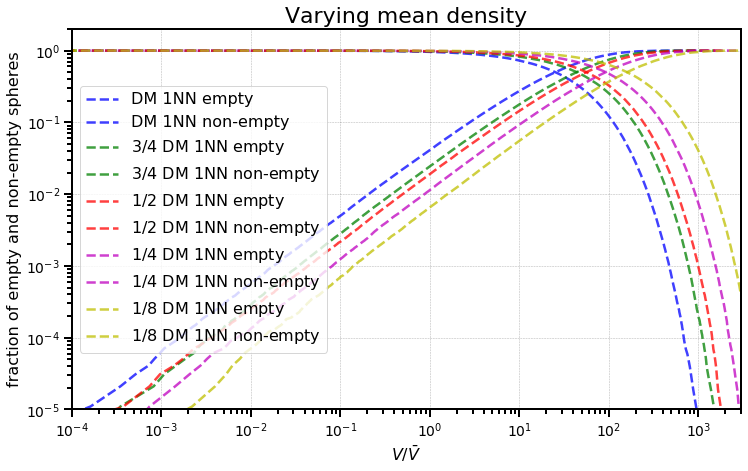

In [61]:
plt.loglog(Vdmg, 1 - CDFdmg, "b--", ms=3, alpha=0.75, label="DM 1NN empty")
plt.loglog(Vdmg, CDFdmg, "b--", ms=3, alpha=0.75, label="DM 1NN non-empty")
plt.loglog(Vdmg34, 1 - CDFdmg34, "g--", ms=3, alpha=0.75, label=r"$3/4$ DM 1NN empty")
plt.loglog(Vdmg34, CDFdmg34, "g--", ms=3, alpha=0.75, label=r"$3/4$ DM 1NN non-empty")
plt.loglog(Vdmg2, 1 - CDFdmg2, "r--", ms=3, alpha=0.75, label=r"$1/2$ DM 1NN empty")
plt.loglog(Vdmg2, CDFdmg2, "r--", ms=3, alpha=0.75, label=r"$1/2$ DM 1NN non-empty")
plt.loglog(Vdmg4, 1 - CDFdmg4, "m--", ms=3, alpha=0.75, label=r"$1/4$ DM 1NN empty")
plt.loglog(Vdmg4, CDFdmg4, "m--", ms=3, alpha=0.75, label=r"$1/4$ DM 1NN non-empty")
plt.loglog(Vdmg8, 1 - CDFdmg8, "y--", ms=3, alpha=0.75, label=r"$1/8$ DM 1NN empty")
plt.loglog(Vdmg8, CDFdmg8, "y--", ms=3, alpha=0.75, label=r"$1/8$ DM 1NN non-empty")

plt.xlabel(r"$V/\bar{V}$")
plt.ylabel("fraction of empty and non-empty spheres")
plt.title("Varying mean density")
plt.xlim(1e-4, 3e3)
plt.ylim(1e-5, 2)
plt.legend()

3 750000 15625000
3 750000 15625000


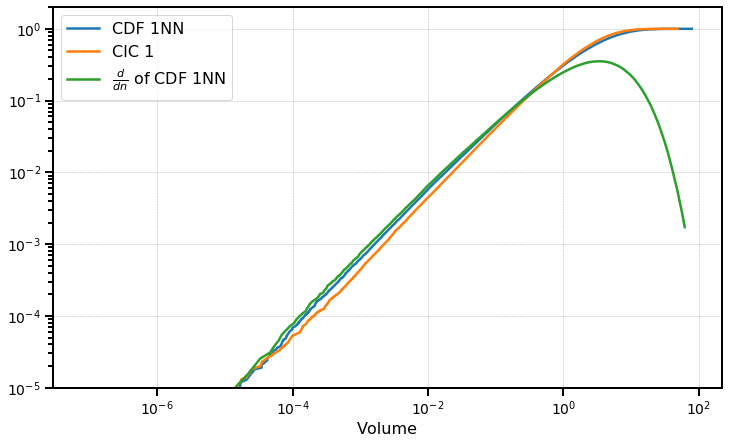

In [62]:
CDF1dm, Vdm1 = VPFkNN(
    xpd[np.random.randint(0, high=Np, size=Np34), :], xoutg, k=1, periodic=250
)
CDF2dm, Vdm2 = VPFkNN(
    xpd[np.random.randint(0, high=Np, size=Np34), :], xoutg, k=2, periodic=250
)

i_CDFdmg2 = interpolate.interp1d(Vdmg2, CDFdmg2, kind=3)

plt.loglog(Vdm1, CDF1dm, label="CDF 1NN")
plt.loglog(Vdm2, CDF2dm, label="CIC 1")
plt.plot(
    Vdmg/250**3*1000000,
    -((1 - CDFdmg) - (1 - i_CDFdmg2(Vdmg))) / (500000) * 750000,
    label=r"$\frac{d}{dn}$ of CDF 1NN",
)
plt.xlabel("Volume")
plt.ylim(1e-5, 2)
plt.legend()

Now let us turn this into a PDF.

NameError: name 'nidm' is not defined

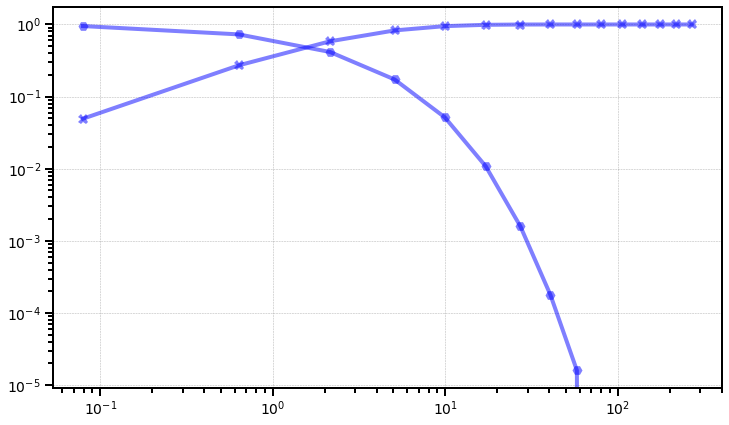

In [66]:
lw = 4
plt.loglog(
    VNN / (250 ** 3 / 1e6),
    vpfr["pN"][:, 0],
    "bH-",
    linewidth=lw,
    alpha=0.5,
    label="dark matter empty",
)
plt.loglog(
    VNN / (250 ** 3 / 1e6),
    1 - vpfr["pN"][:, 0],
    "bX-",
    linewidth=lw,
    alpha=0.5,
    label="dark matter non-empty",
)
# plt.loglog(VNN/(250**3/Nhthresh[0]), vpfh1["pN"][:,0], 'X-',linewidth=lw, label="$5\cdot 10^{10} < M < 10^{11}$")
# plt.loglog(VNN/(250**3/Nhthresh[1]), vpfh2["pN"][:,0], 'X-',linewidth=lw, label="$ 10^{11} < M < 10^{12}$")
# plt.loglog(VNN/(250**3/Nhthresh[2]), vpfh3["pN"][:,0], 'X-',linewidth=lw, label="$10^{12} < M < 10^{13}$")
# plt.loglog(VNN/(250**3/Nhthresh[3]), vpfh4["pN"][:,0], 'X-',linewidth=lw, label="$10^{13} < M < 10^{14}$")
# plt.loglog(VNN/(250**3/Nhthresh[4]), vpfh5["pN"][:,0], 'X-',linewidth=lw, label="$ 10^{14} < M $")

Vsdm = Vdmg

plt.plot(Vsdm, 1 - nidm / Npdm, "g--", ms=3, alpha=0.5, label="dark matter 1NN empty")
plt.plot(Vsdm, nidm / Npdm, "g-", ms=3, alpha=0.5, label="dark matter 1NN non-empty")

plt.xlabel(r"$V/\bar{V}$")
plt.ylabel("fraction of empty and non-empty spheres")
plt.title("Comparison of 1NN and empty sphere estimator")
plt.xlim(1e-4, 3e2)
plt.ylim(1e-5, 2)
plt.legend()

In [64]:
bine = np.logspace(-5, 2, 800)
hVsdm = np.histogram(Vsdm, bins=bine, density=True)
binw = bine[1:] - bine[:-1]
binc = (bine[1:] + bine[:-1]) / 2
# plt.loglog(binc, hVsdm[0] , '.' )
plt.plot(Vsdm, 1 - nidm / Npdm, "g--", ms=3, alpha=0.5, label="dark matter 1NN empty")
plt.loglog(
    VNN / (250 ** 3 / 1e6),
    vpfr["pN"][:, 0],
    "bH-",
    linewidth=lw,
    alpha=0.5,
    label="dark matter VPF empty",
)
plt.loglog(
    binc,
    1 - np.cumsum(binw * hVsdm[0]),
    "r--",
    linewidth=lw,
    alpha=0.5,
    label="dark matter 1NN empty",
)
plt.plot(
    Vsdm,
    (1 - nidm / Npdm) * Vsdm,
    "g--",
    ms=3,
    alpha=0.5,
    label=r"$V\cdot P_{1NN}\{\Phi_0(V)\}$ ",
)

plt.ylim(1e-8, 1.5)
plt.legend()

NameError: name 'Vsdm' is not defined

In [ ]:
Npdm = len(rdm)
nidm = np.arange(0, Npdm) + 1

Ned = 1600000000
skip = 30000
gr = np.gradient((Vsdm * (1 - nidm / Npdm))[0:Ned:skip], Vsdm[0:Ned:skip])
# plt.plot(Vsdm[0:Ned:skip], (1-nidm/Npdm)[0:Ned:skip],  "gh-", ms=6, alpha=.5, label="dark matter 1NN empty" )
plt.plot(Vsdm[0:Ned:skip], gr, "g", ms=3, alpha=0.5, label="dark matter 1NN empty")

In [ ]:
plt.plot(
    np.log10(Vsdm)[10:],
    np.log10(nidm / Npdm / Vsdm)[10:],
    "g.",
    ms=3,
    alpha=0.5,
    label="f(1-f)",
)
plt.plot(
    np.log10(Vsdmg)[10:],
    np.log10(CDFdmg / Vsdmg)[10:],
    "b.",
    ms=3,
    alpha=0.5,
    label="f(1-f)",
)

In [ ]:
from scipy.optimize import curve_fit

skip = 10
xdata = np.log10(Vsdmg)[skip::skip]
ydata = np.log10(CDFdmg / Vsdmg)[skip::skip]


def func(x, a, b, c, d, e, f, g, h):
    return (
        h * x ** 7
        + g * x ** 6
        + f * x ** 5
        + e * x ** 4
        + d * x ** 3
        + c * x ** 2
        + b * x
        + a
    )


popt, pcov = curve_fit(func, xdata, ydata)
print(popt)

plt.plot(xdata, ydata, "b-", alpha=0.3, label="data")
plt.plot(xdata, func(xdata, *popt), "gx--", alpha=0.3, label="fit")
plt.legend()

In [ ]:
plt.plot(
    np.log10(Vsdm)[100:],
    np.log10(1 - nidm / Npdm)[100:],
    "g.",
    ms=3,
    alpha=0.5,
    label="f(1-f)",
)
plt.plot(
    np.log10(Vsdm)[1000:],
    -1 + np.log10(Vsdm)[1000:] * func(np.log10(Vsdm)[1000:], *popt),
)
plt.legend()

In [779]:
Ned

1600000

In [783]:
len(rsdm)

1000000

In [782]:
np.arange(10)[0:10:2]

array([0, 2, 4, 6, 8])

In [65]:

Npdm = len(rsdm)
nidm = np.arange(0, Npdm) + 1

Vsdm = 1.0 / rdm[:, 0]
Vsdm.sort()

NameError: name 'rsdm' is not defined